In [2]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import patch
import kinematics

In [3]:
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

In [4]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [5]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

In [6]:
def PlotStates(hmm_z, mouse_pos, N):
    color_names = ["blue","red","yellow", "green","brown","purple","orange"]
    colors = sns.xkcd_palette(color_names[0:N])
    cmap = gradient_cmap(colors)

    times = pd.to_datetime(mouse_pos.index)
    numerical_times = (times - times[0]).total_seconds().values
    states_array = hmm_z.reshape(1, -1)
    
    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    extent = [numerical_times[0], numerical_times[-1], 0, 1]
    cax = axs.imshow(states_array, aspect="auto", cmap=cmap, vmin=0, vmax=N-1, extent=extent)
    
    axs.set_xlabel('Time')
    axs.set_xticks(numerical_times[::len(numerical_times)//10])
    axs.set_xticklabels([time.strftime('%H:%M:%S') for time in times[::len(times)//10]], rotation=45, ha='right')
    
    axs.set_ylabel("States")
    axs.set_yticks([])

    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, N))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, N)])
    
    plt.tight_layout()
    plt.show()

# Choose Valid Sessions

In [7]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Long Sessions

LongSession0


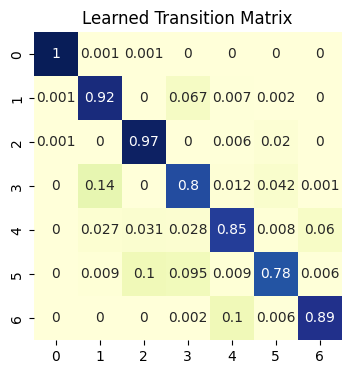

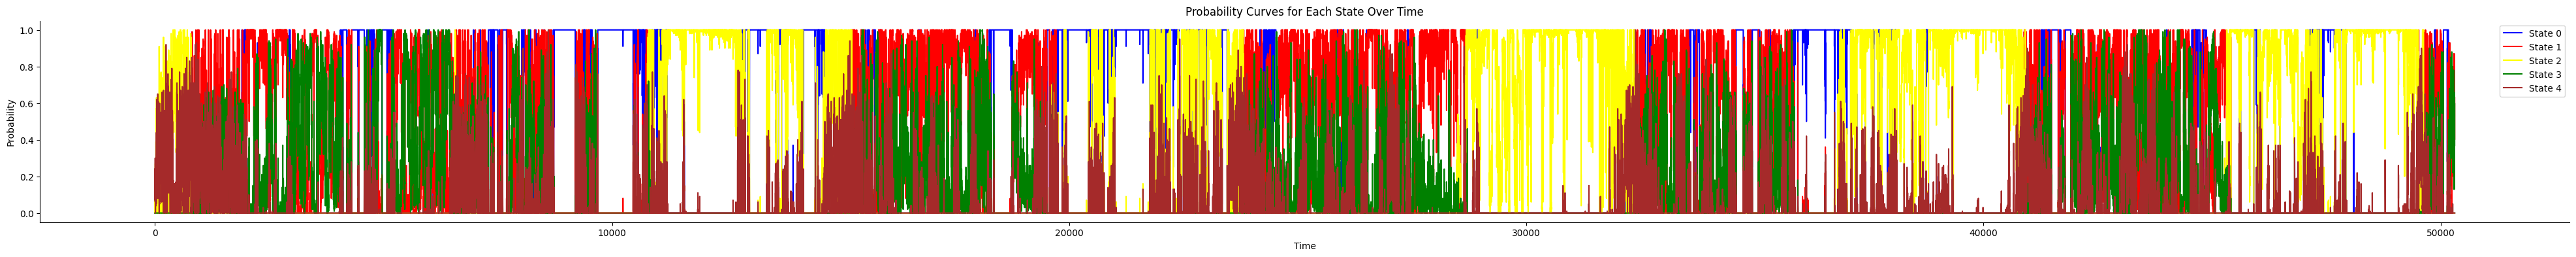

LongSession1


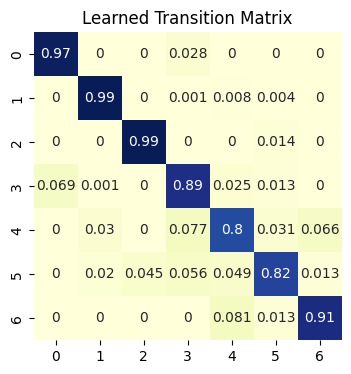

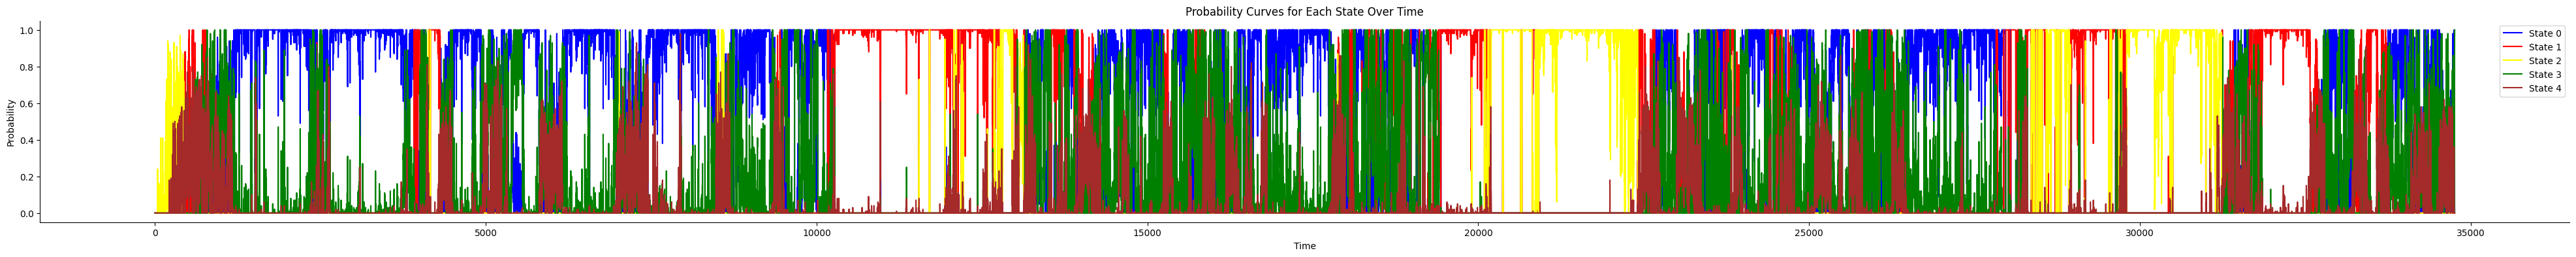

In [6]:
color_names = ["blue","red","yellow", "green","brown","purple","orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

N = 7

for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 1: continue
    title = 'LongSession'+str(j)
    print(title)
    
    transition_mat =  np.load(title+"Transition_2.npy", allow_pickle=True)
    annot_array = np.array([[round(item, 3) for item in row] for row in transition_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(transition_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Learned Transition Matrix")
    plt.show() 
    
    states = np.load(title+"States_2.npy", allow_pickle = True)

    num_bins = len(states) // 100

    # Reshape the array to segment into bins of 100, ignoring the remainder for now
    bins = states[:num_bins * 100].reshape(-1, 100)

    # Initialize a dictionary to hold the probabilities for each state
    state_probabilities = {state: [] for state in np.unique(states)}

    # Calculate the probabilities for each bin
    for bin in bins:
        # Count the occurrences of each state in the bin
        counts = np.bincount(bin, minlength=len(state_probabilities))
        
        # Calculate the probability for each state and update the dictionary
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)

    # If you have a remainder, calculate its state probabilities separately
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    fig, axs = plt.subplots(1,1,figsize = (50, 4))
    for state in range(5): 
        axs.plot(state_probabilities[state], label=f'State {state}', color = color_names[state])

    axs.set_xlabel('Time')
    axs.set_ylabel('Probability')
    axs.set_title('Probability Curves for Each State Over Time')
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.legend()
    plt.show()

LongSession0


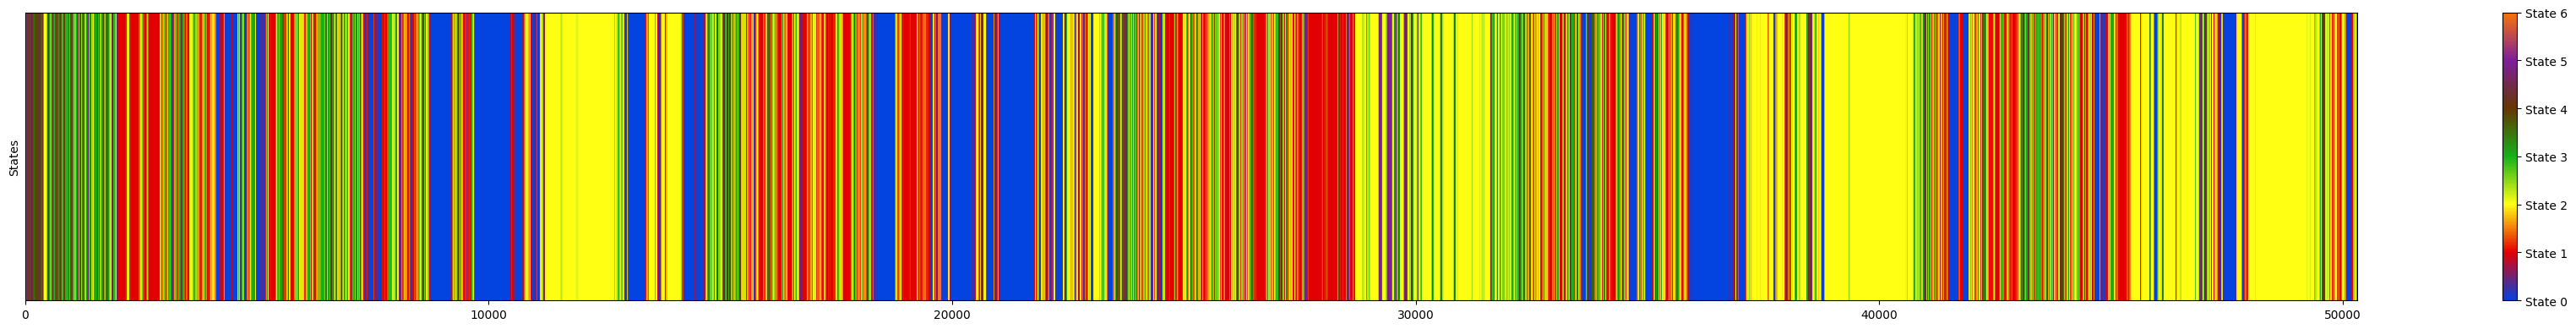

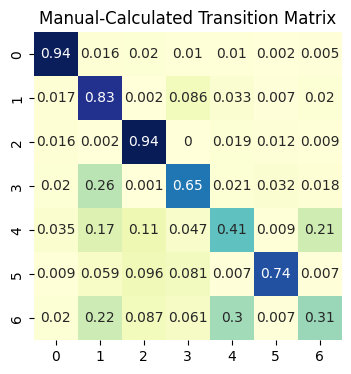

LongSession1


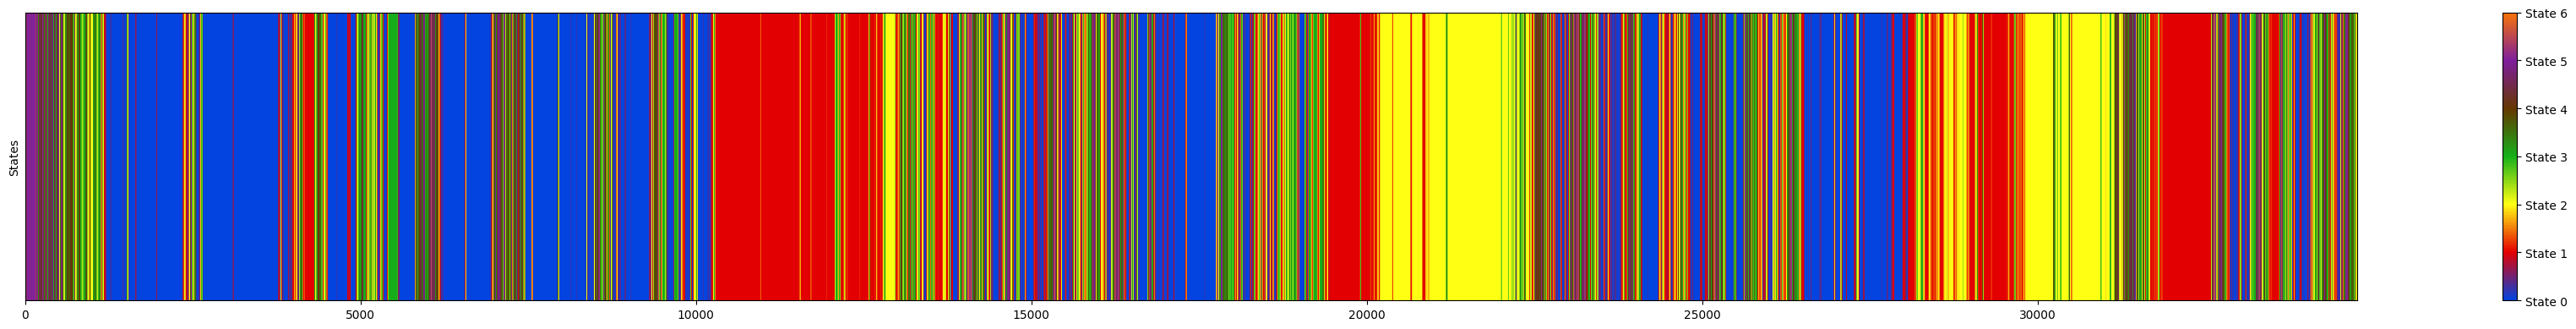

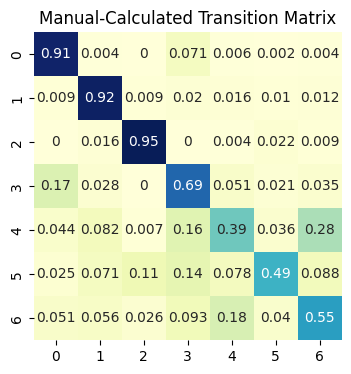

In [38]:
N = 7
for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 1: continue
    title = 'LongSession'+str(j)
    print(title)

    states = np.load(title+"States_2.npy", allow_pickle = True)

    num_bins = len(states) // 100
    bins = states[:num_bins * 100].reshape(-1, 100)
    state_probabilities = {state: [] for state in np.unique(states)}

    for bin in bins:
        counts = np.bincount(bin, minlength=len(state_probabilities))

        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / 100.0)
            
    remainder = len(states) % 100
    if remainder != 0:
        last_bin = states[-remainder:]
        counts = np.bincount(last_bin, minlength=len(state_probabilities))
        for state in state_probabilities:
            state_probabilities[state].append(counts[state] / remainder)
    
    x = np.array([list(state_probabilities[i]) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))


    fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    cax = axs.imshow(np.array(states_).reshape(1,-1), aspect="auto", cmap=cmap, vmin=0, vmax=np.max(states_))
    axs.set_ylabel("States")
    axs.set_yticks([])
    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, np.max(states_) + 1))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, np.max(states_) + 1)])   
    plt.tight_layout()
    plt.show()
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1

    for i in range(N): manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 3) for item in row] for row in manual_trans_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Manual-Calculated Transition Matrix")
    plt.show()

## Session 0

In [ ]:
N = 7
for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j > 0: continue
    title = 'LongSession'+str(j)
    print(title)
                                
    start, end = session.enter, session.exit
    mouse = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    mouse = kinematics.ProcessRawData(mouse, root, start, end)
            
    patch.AddKinematics(title, mouse)
            
    mouse_pos_subs = patch.SeparateDF(mouse)

    dfs = []
    for mouse_pos_sub in mouse_pos_subs:
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_speed'] <= 2000]
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_acceleration'] <= 60000]
        mouse_pos_sub = patch.DeleteRows(mouse_pos_sub)

        mouse_pos_sub = mouse_pos_sub.loc[:,['x']]
                
        dfs.append(mouse_pos_sub)

    mouse_pos = dfs[0]
    for df in dfs[1:]: mouse_pos = mouse_pos.add(df, fill_value=0)
    
    states = np.load(title+"States_2.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    

    grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'states']).size()
    prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
    states_prob = prob.unstack(level=-1).fillna(0)
    states_prob.index = states_prob.index.get_level_values(0)
    
    for i in range(N):
        if i not in states_prob.columns: states_prob[i] = 0
    
    x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))
    
    PlotStates(np.array(states_), states_prob, N=7)

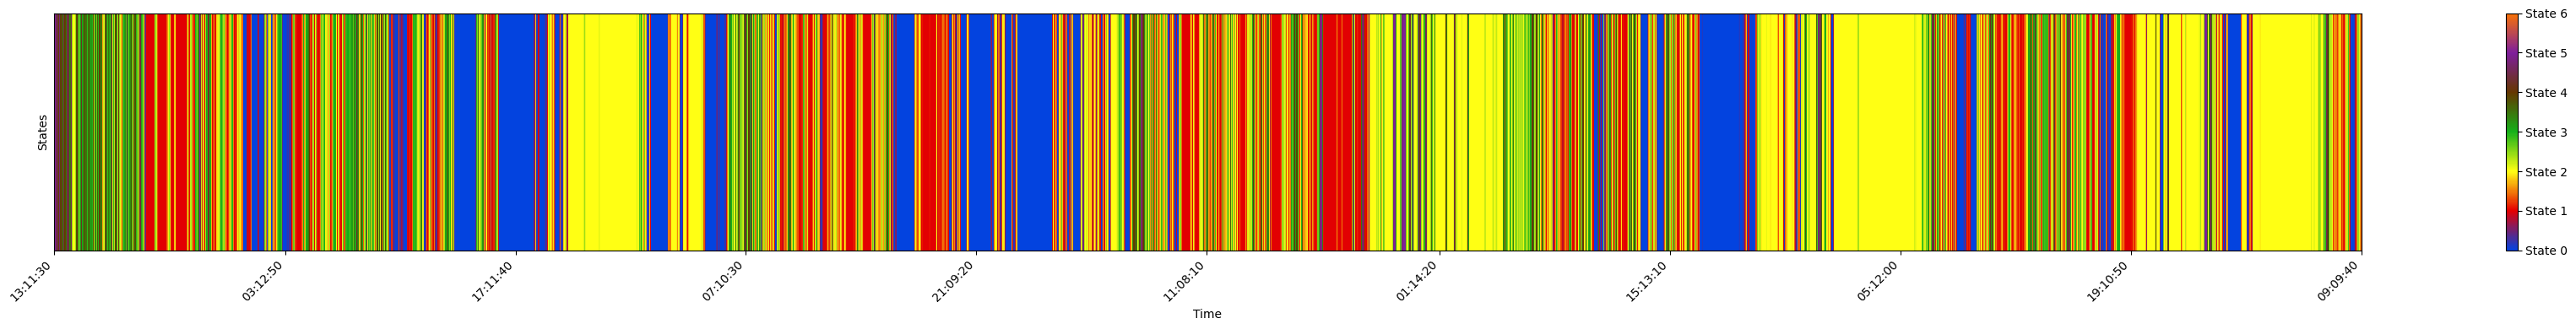

In [8]:
N = 7
for i in range(N):
    if i not in states_prob.columns: states_prob[i] = 0
    
x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

states_ = []
for i in range(len(x[0])):
    current_state = x.T[i]
    states_.append(np.argmax(current_state))
    
PlotStates(np.array(states_), states_prob, N=7)

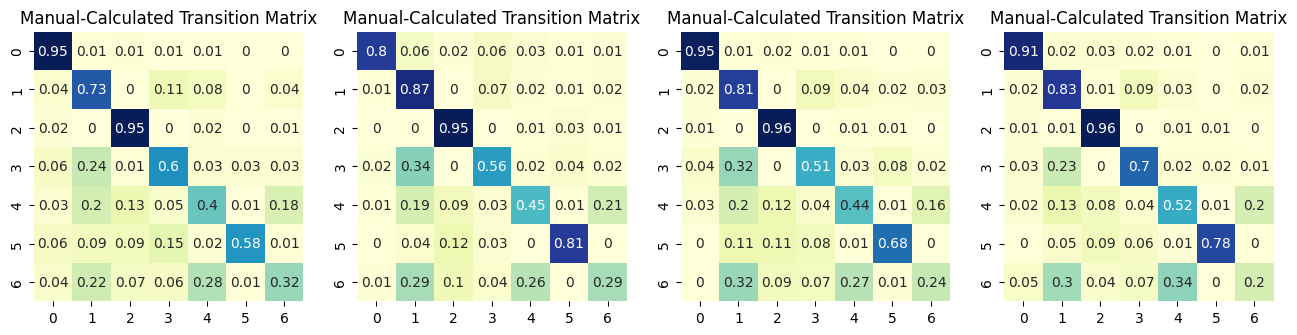

In [13]:
START = ['2022-03-30 07:00:00','2022-04-01 07:00:00','2022-04-02 07:00:00','2022-04-03 07:00:00']
END = ['2022-03-31 07:00:00','2022-04-02 07:00:00','2022-04-03 07:00:00','2022-04-04 07:00:00']
#states_prob['states'] = pd.Series(states_, index=states_prob.index)
fig, axs = plt.subplots(1,4, figsize=(16, 4))
for j in range(len(START)):
    start, end = pd.Timestamp(START[j]),pd.Timestamp(END[j])
    period_data = states_prob.loc[start:end]
    states_ = period_data['states'].to_numpy()
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1
    for i in range(N): 
        if np.sum(manual_trans_mat[i]) != 0: manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 2) for item in row] for row in manual_trans_mat])
    
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs[j], square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs[j].set_title("Manual-Calculated Transition Matrix")
plt.show()

## Session 1

LongSession1


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for CameraTop_200_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


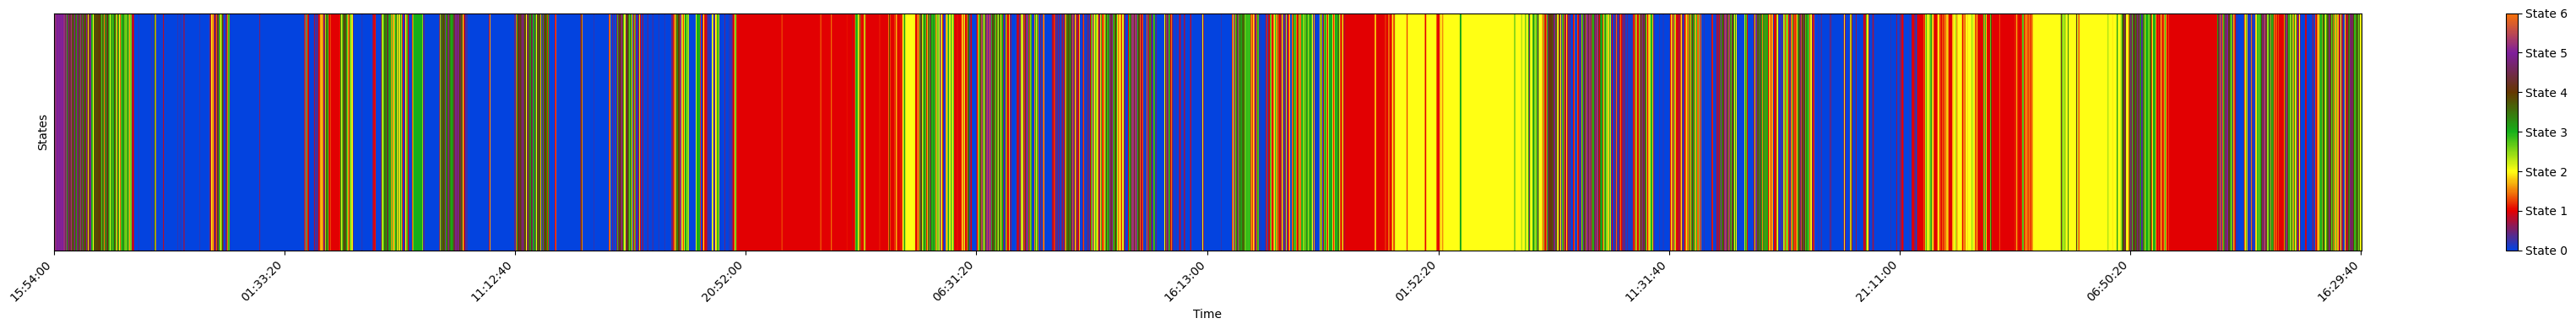

In [7]:
N = 7
for session, j in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if j != 1: continue
    title = 'LongSession'+str(j)
    print(title)
                                
    start, end = session.enter, session.exit
    mouse = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
    mouse = kinematics.ProcessRawData(mouse, root, start, end)
            
    patch.AddKinematics(title, mouse)
            
    mouse_pos_subs = patch.SeparateDF(mouse)

    dfs = []
    for mouse_pos_sub in mouse_pos_subs:
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_speed'] <= 2000]
        mouse_pos_sub = mouse_pos_sub[mouse_pos_sub['smoothed_acceleration'] <= 60000]
        mouse_pos_sub = patch.DeleteRows(mouse_pos_sub)

        mouse_pos_sub = mouse_pos_sub.loc[:,['x']]
                
        dfs.append(mouse_pos_sub)

    mouse_pos = dfs[0]
    for df in dfs[1:]: mouse_pos = mouse_pos.add(df, fill_value=0)
    
    states = np.load(title+"States_2.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    

    grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'states']).size()
    prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
    states_prob = prob.unstack(level=-1).fillna(0)
    states_prob.index = states_prob.index.get_level_values(0)
    
    for i in range(N):
        if i not in states_prob.columns: states_prob[i] = 0
    
    x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))
    
    PlotStates(np.array(states_), states_prob, N=7)

In [8]:
states_prob

states,0,1,2,3,4,5,6
2022-04-04 15:54:00,0.00,0.0,0.0,0.00,0.0,1.000000,0.000000
2022-04-04 15:54:10,0.00,0.0,0.0,0.00,0.0,0.450000,0.550000
2022-04-04 15:54:20,0.00,0.0,0.0,0.00,0.0,0.240000,0.760000
2022-04-04 15:54:30,0.00,0.0,0.0,0.00,0.0,0.777778,0.222222
2022-04-04 15:54:40,0.00,0.0,0.0,0.00,0.0,0.690000,0.310000
...,...,...,...,...,...,...,...
2022-04-08 16:30:20,0.76,0.0,0.0,0.24,0.0,0.000000,0.000000
2022-04-08 16:30:30,0.90,0.0,0.0,0.10,0.0,0.000000,0.000000
2022-04-08 16:30:40,0.06,0.0,0.0,0.94,0.0,0.000000,0.000000
2022-04-08 16:30:50,0.05,0.0,0.0,0.95,0.0,0.000000,0.000000


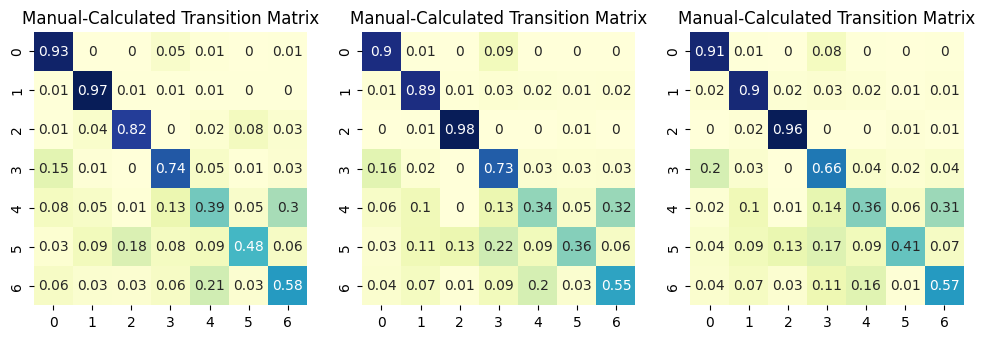

In [11]:
START = ['2022-04-05 07:00:00','2022-04-06 07:00:00','2022-04-07 07:00:00']
END = ['2022-04-06 07:00:00','2022-04-07 07:00:00','2022-04-08 07:00:00']
#states_prob['states'] = pd.Series(states_, index=states_prob.index)
fig, axs = plt.subplots(1,len(START), figsize=(4*len(START), 4))
for j in range(len(START)):
    start, end = pd.Timestamp(START[j]),pd.Timestamp(END[j])
    period_data = states_prob.loc[start:end]
    states_ = period_data['states'].to_numpy()
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1
    for i in range(N): 
        if np.sum(manual_trans_mat[i]) != 0: manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 2) for item in row] for row in manual_trans_mat])
    
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs[j], square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs[j].set_title("Manual-Calculated Transition Matrix")
plt.show()

# Short Sessions

ShortSession9


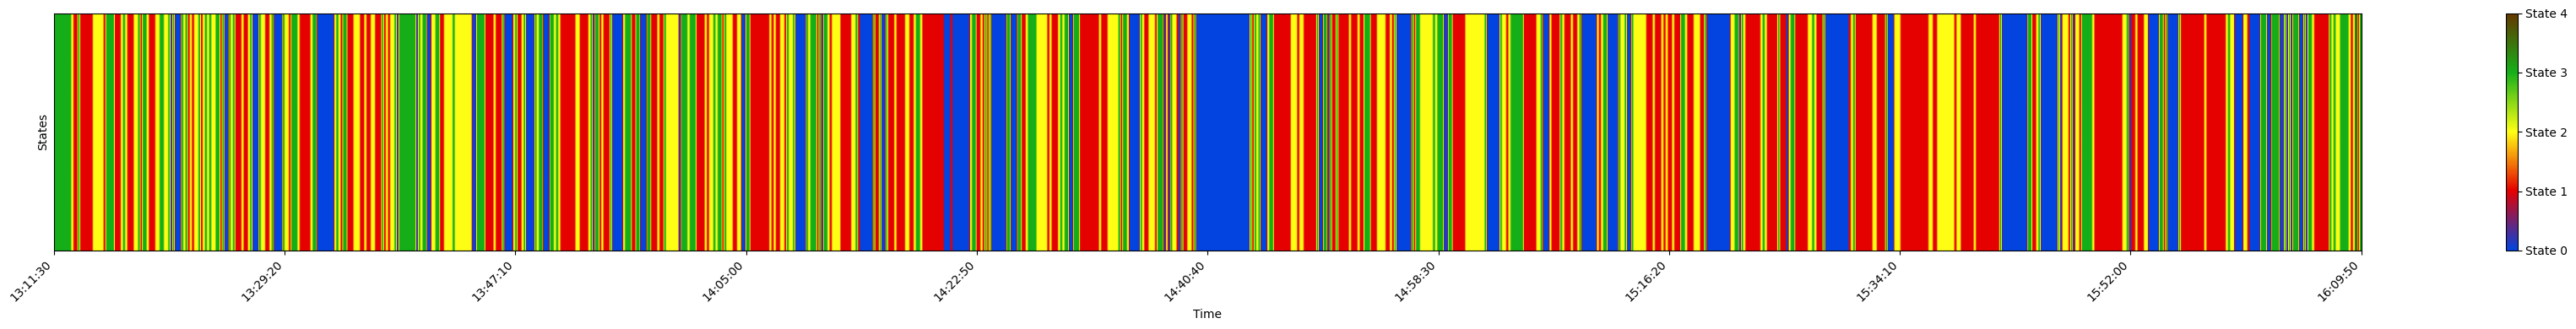

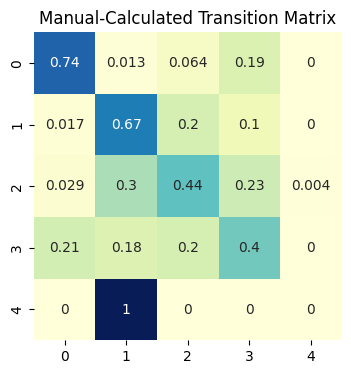

In [8]:
N = 5
for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if j != 9: continue
    title = 'ShortSession'+str(j)
    print(title)
    
    states = np.load(title+"States.npy", allow_pickle = True)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = patch.DeleteRows(mouse_pos)

    states = np.load(title+"States.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    

    grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'states']).size()
    prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
    states_prob = prob.unstack(level=-1).fillna(0)
    states_prob.index = states_prob.index.get_level_values(0)
    
    for i in range(N):
        if i not in states_prob.columns: states_prob[i] = 0
        #states_prob.iloc[0, states_prob.columns.get_loc(i)] = 1e-5
    
    x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))
    
    PlotStates(np.array(states_), states_prob, N=5)
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1

    for i in range(N): 
        if np.sum(manual_trans_mat[i]) != 0: manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 3) for item in row] for row in manual_trans_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Manual-Calculated Transition Matrix")
    plt.show()

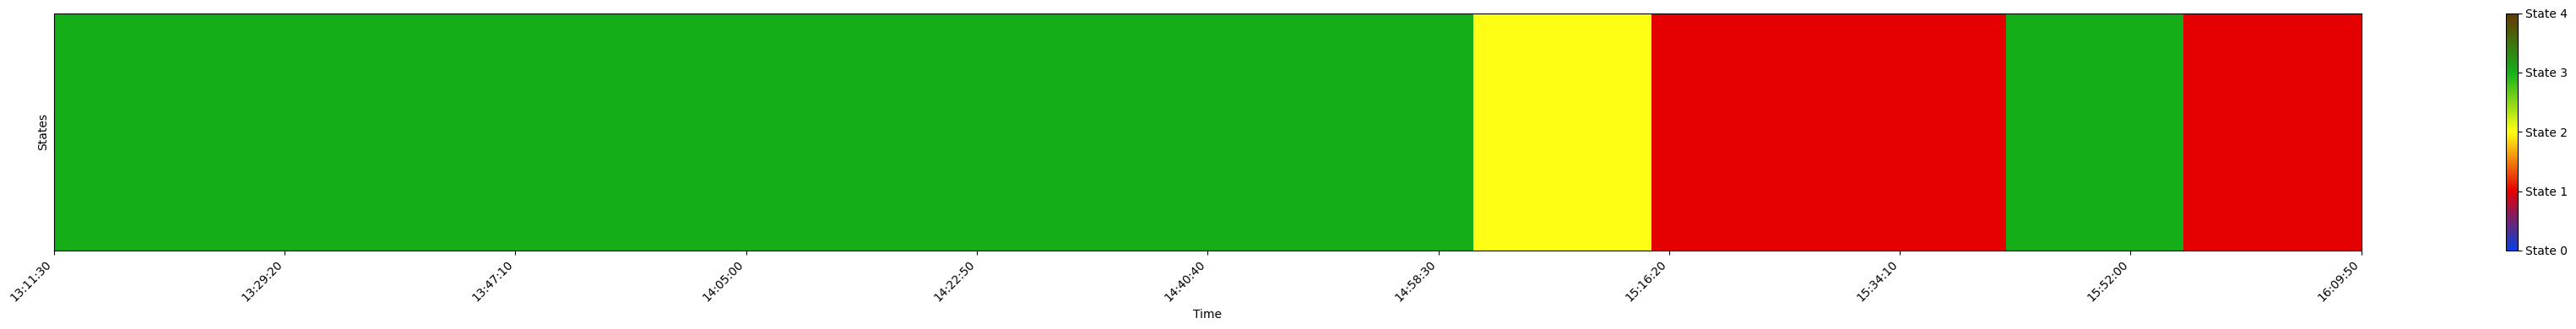

In [14]:
START = ['2022-08-15 13:11:30']
END = ['2022-08-15 13:13:30']
#states_prob['states'] = pd.Series(states_, index=states_prob.index)
for j in range(len(START)):
    start, end = pd.Timestamp(START[j]),pd.Timestamp(END[j])
    period_data = states_prob.loc[start:end]
    states_ = period_data['states'].to_numpy()
    
    PlotStates(np.array(states_), states_prob, N=5)

In [10]:
states_prob

states,0,1,2,3,4
2022-08-15 13:11:30,0.00,0.020202,0.272727,0.696970,0.010101
2022-08-15 13:11:40,0.24,0.090000,0.050000,0.570000,0.050000
2022-08-15 13:11:50,0.06,0.090000,0.200000,0.640000,0.010000
2022-08-15 13:12:00,0.00,0.080000,0.380000,0.460000,0.080000
2022-08-15 13:12:10,0.00,0.090000,0.150000,0.760000,0.000000
...,...,...,...,...,...
2022-08-15 16:09:10,0.00,0.530612,0.336735,0.081633,0.051020
2022-08-15 16:09:20,0.00,0.316327,0.520408,0.051020,0.112245
2022-08-15 16:09:30,0.00,0.262626,0.222222,0.222222,0.292929
2022-08-15 16:09:40,0.00,0.400000,0.189474,0.094737,0.315789


ShortSession0


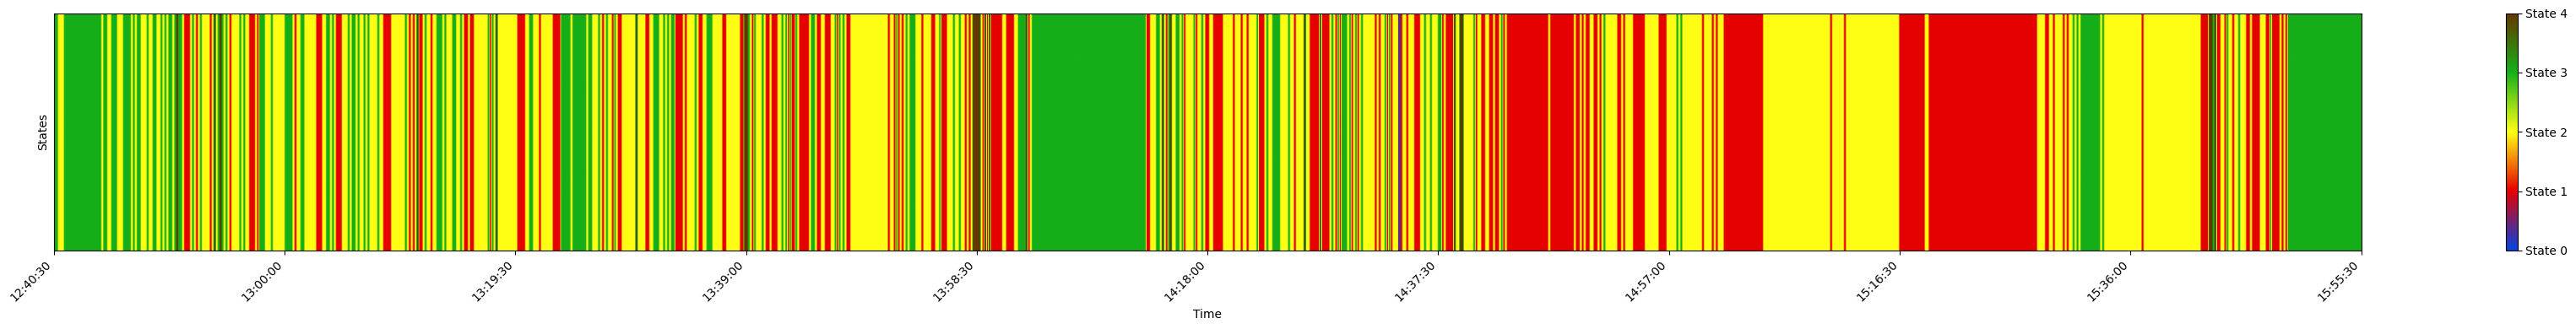

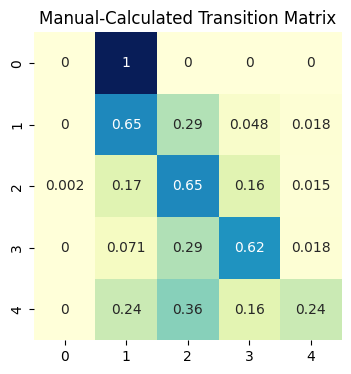

ShortSession1


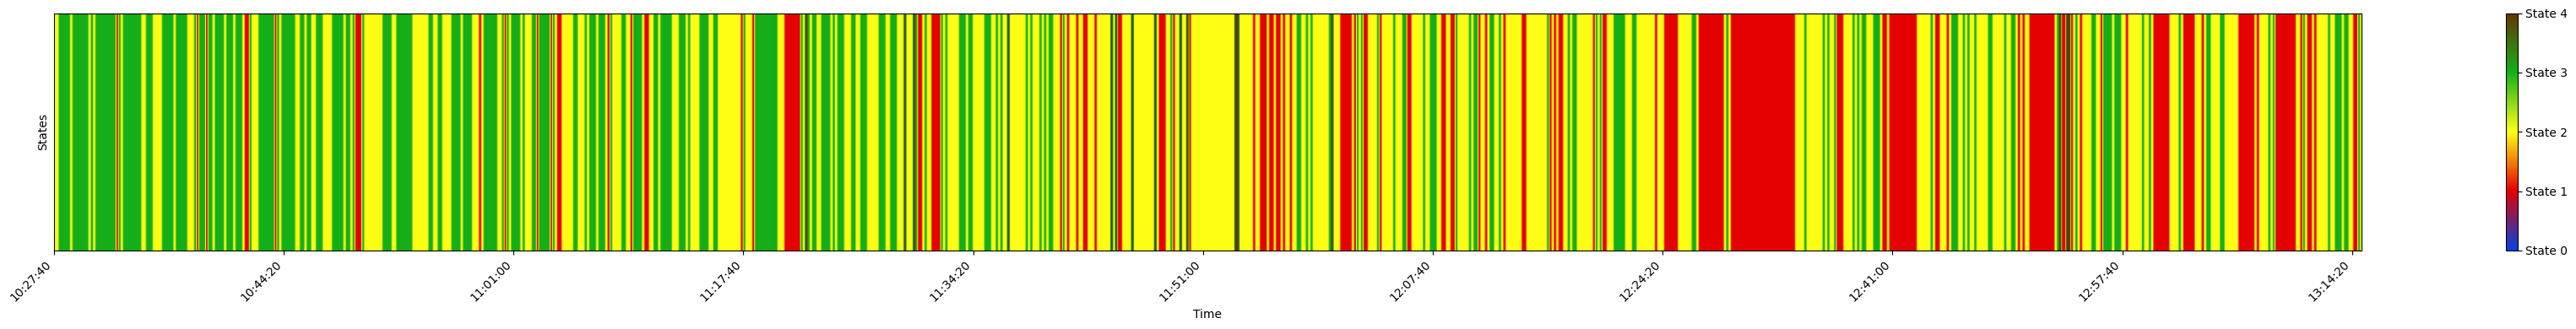

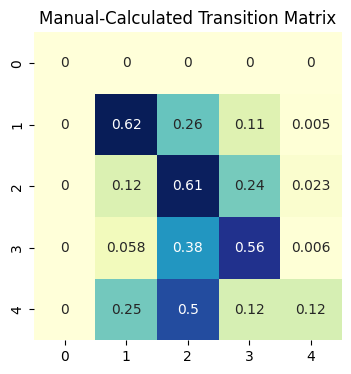

ShortSession2


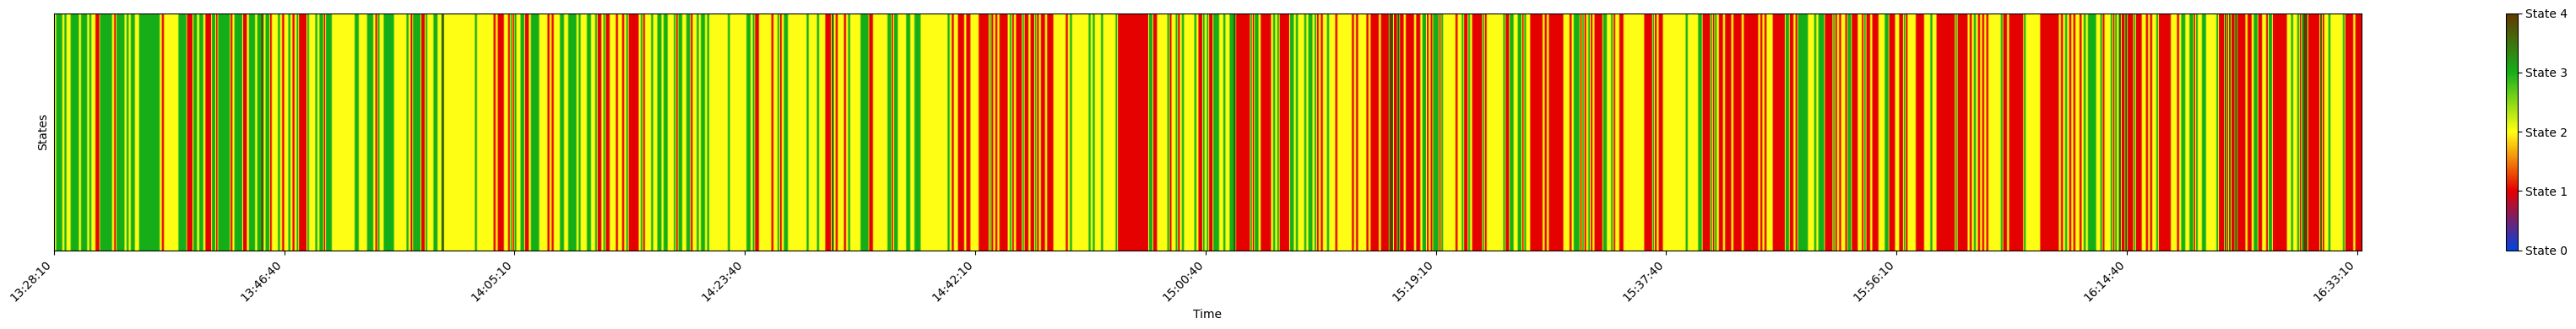

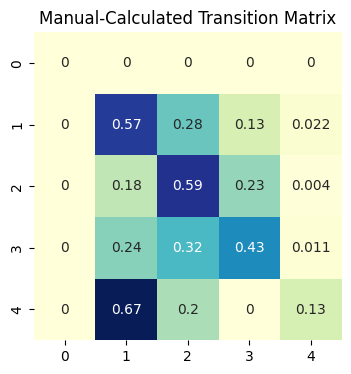

ShortSession3


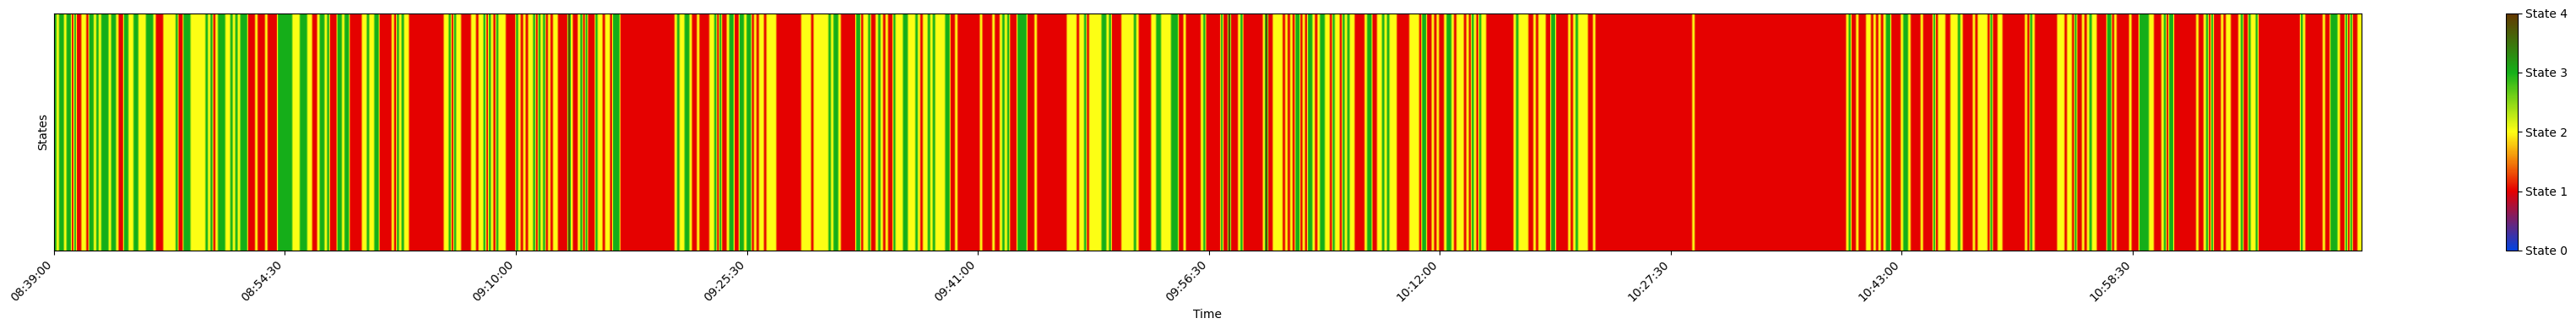

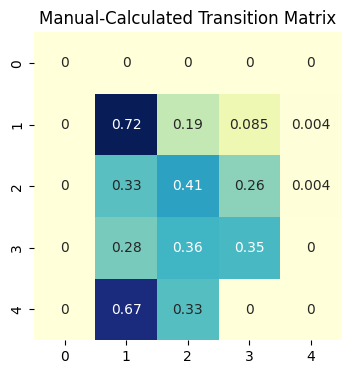

ShortSession4


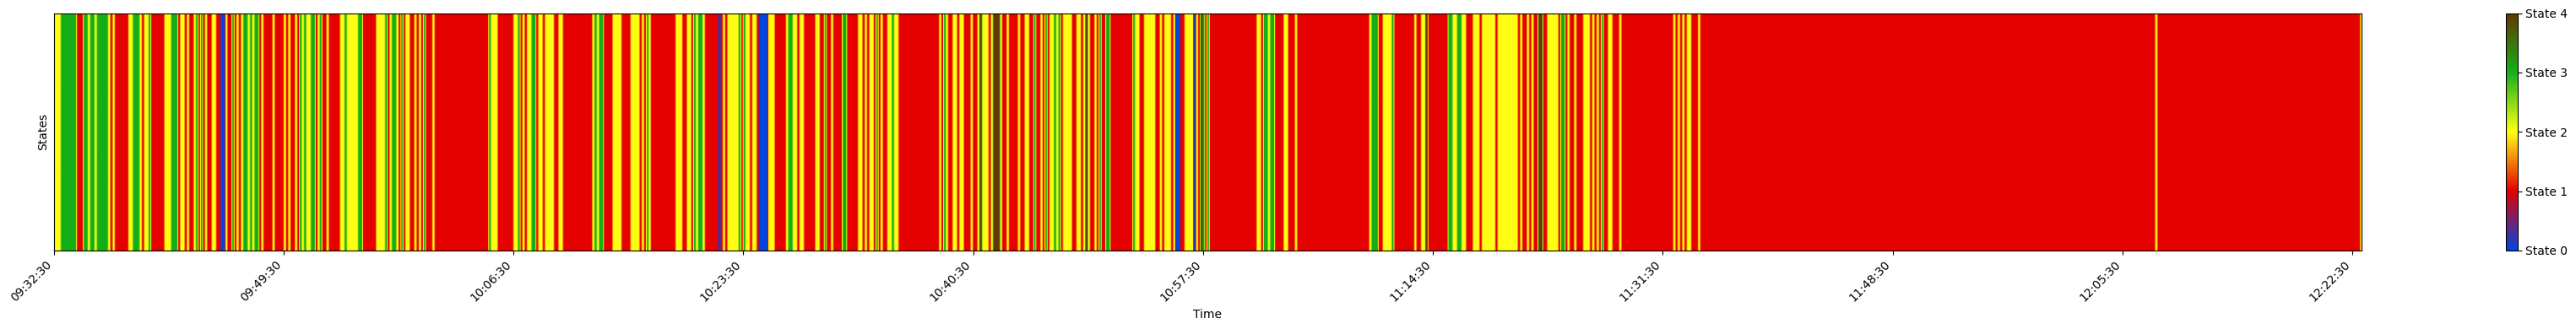

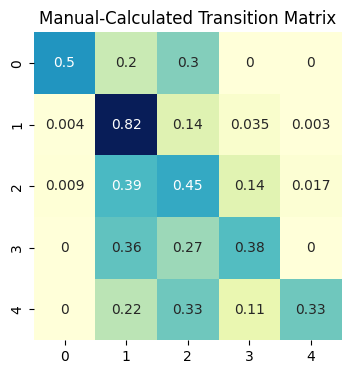

ShortSession5


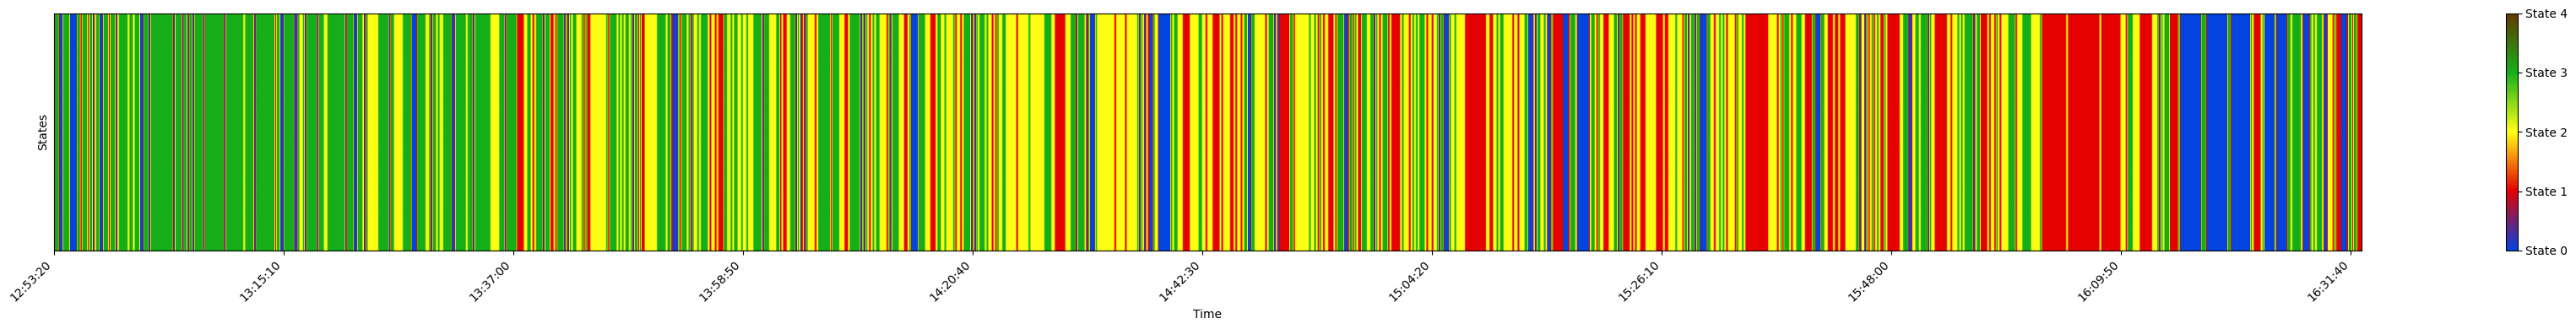

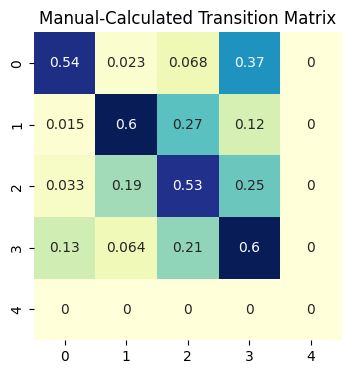

ShortSession6


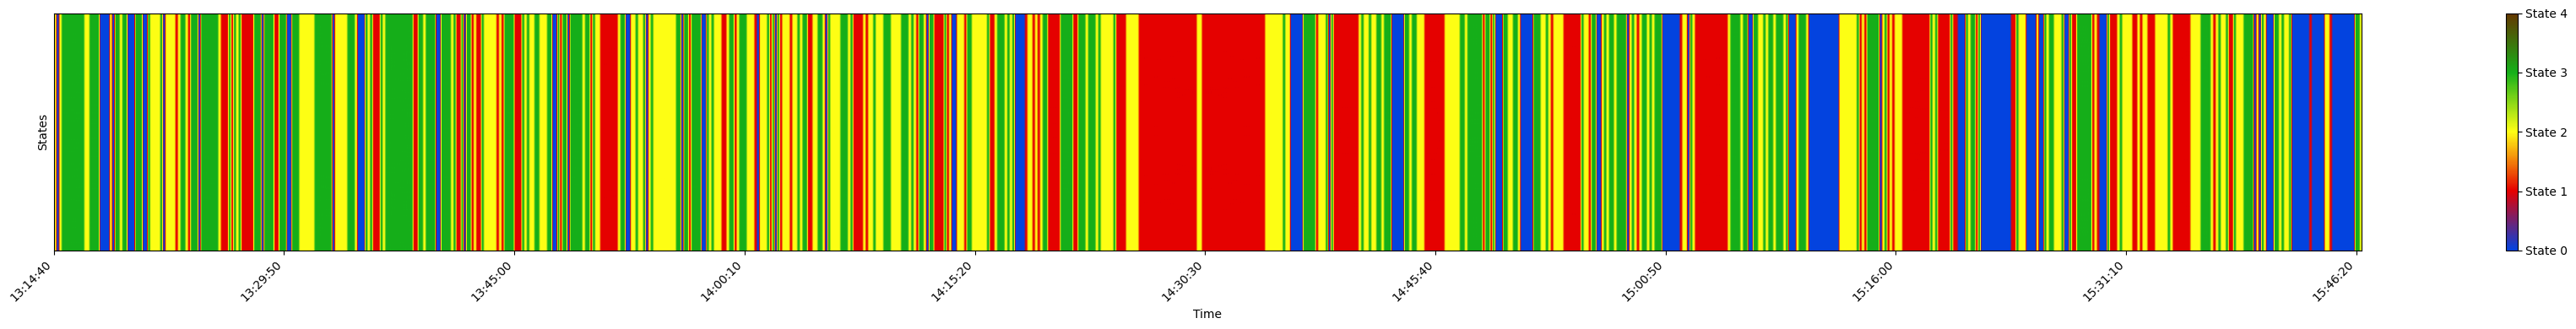

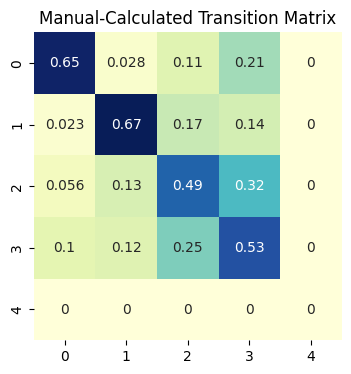

ShortSession7


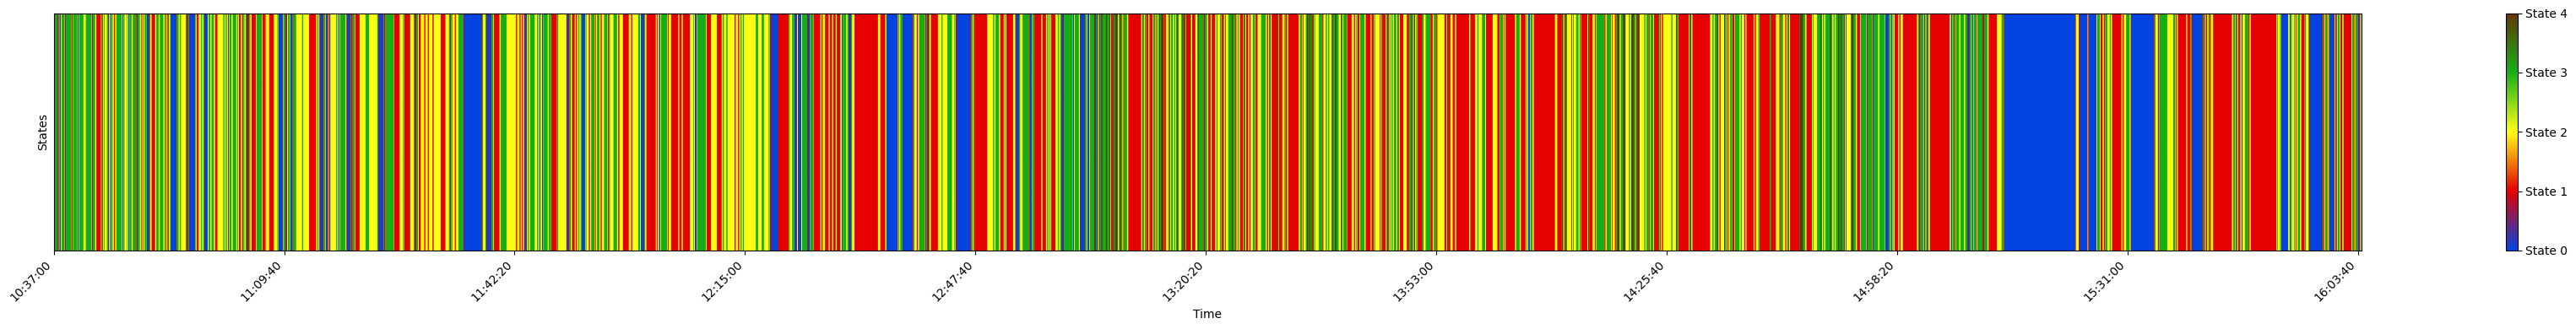

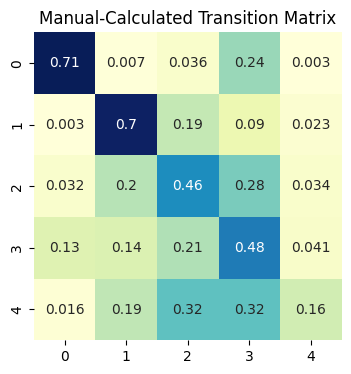

ShortSession8


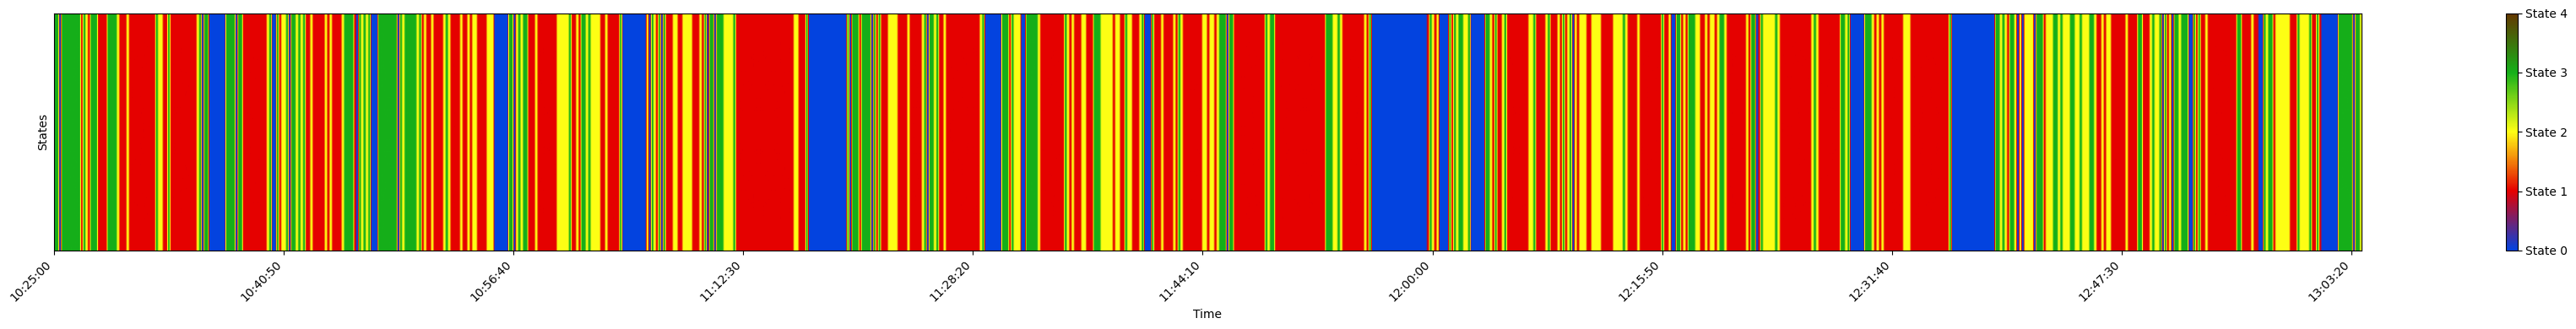

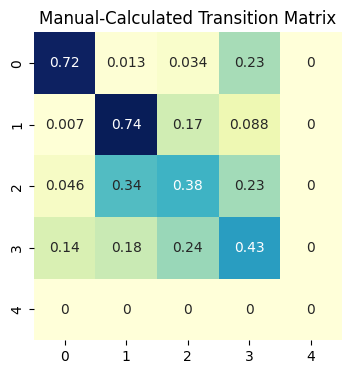

ShortSession9


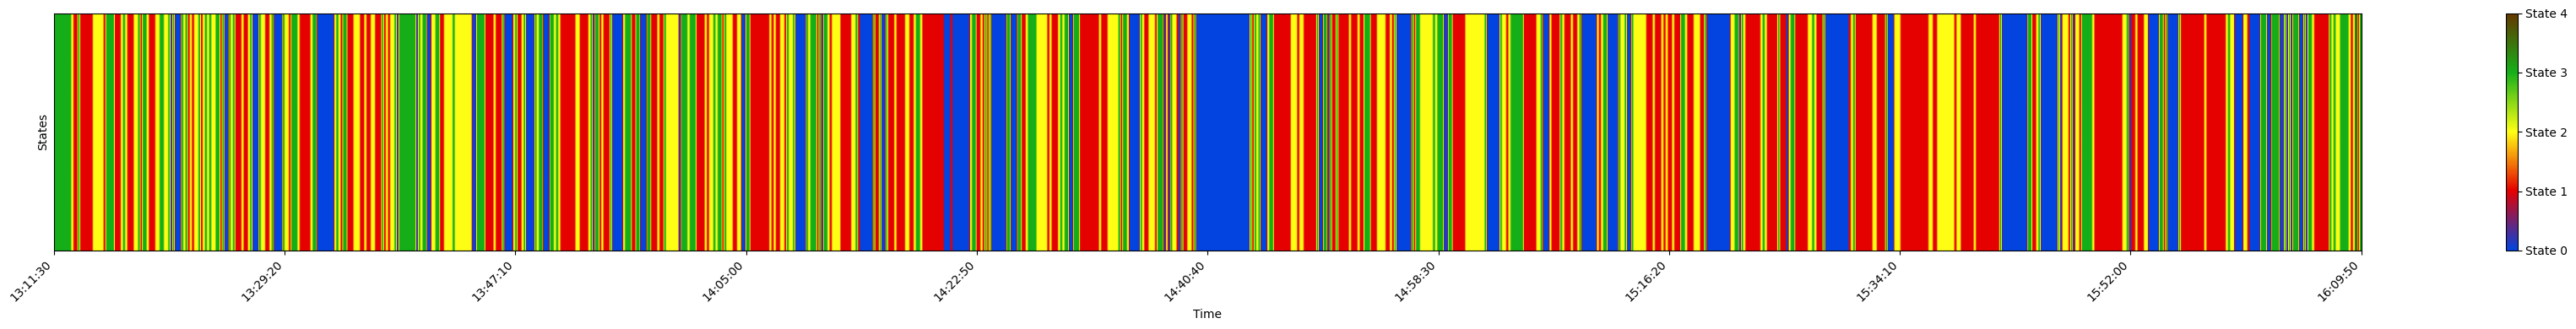

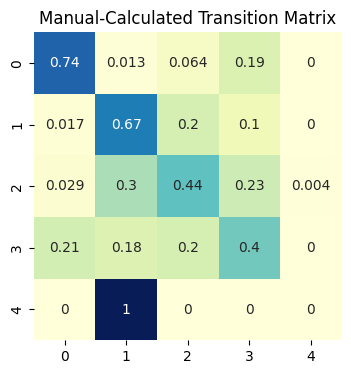

ShortSession10


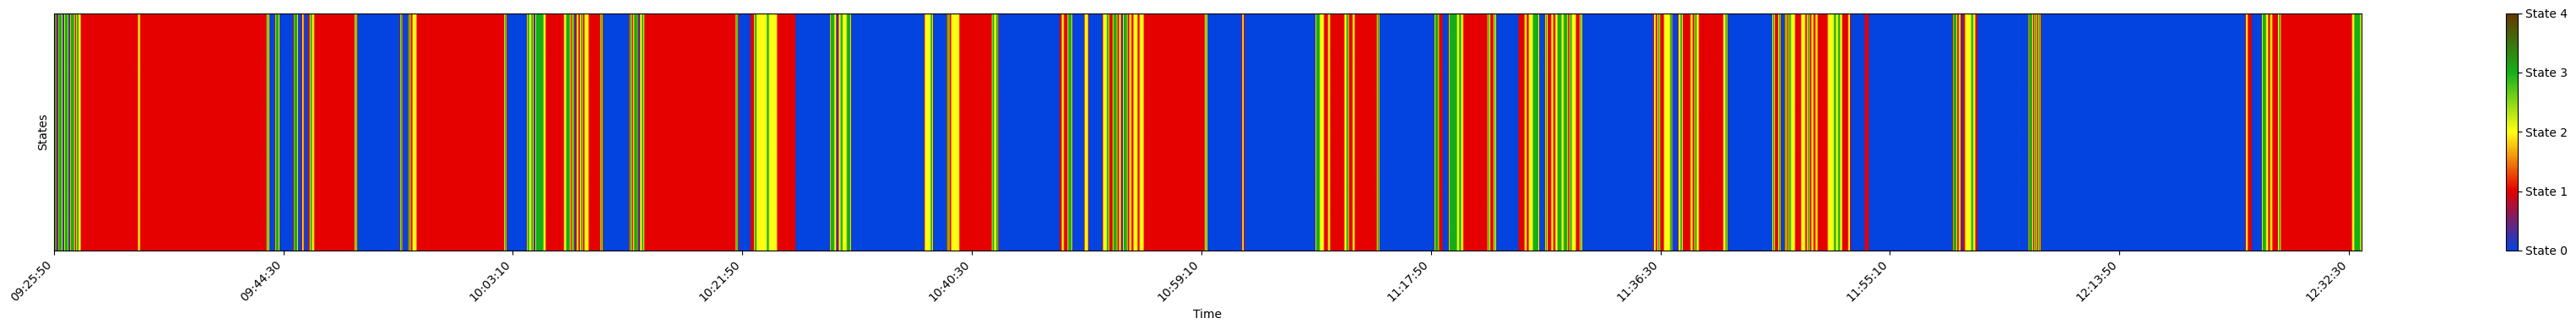

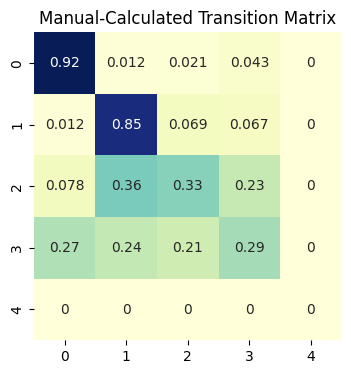

ShortSession11


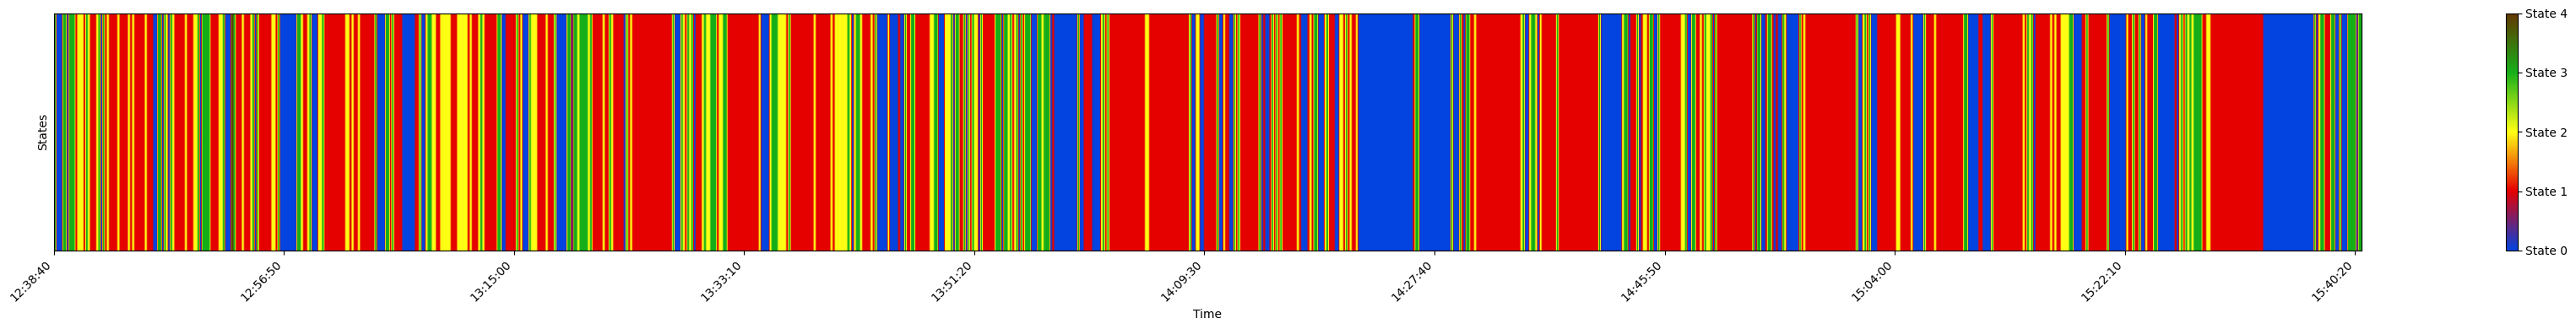

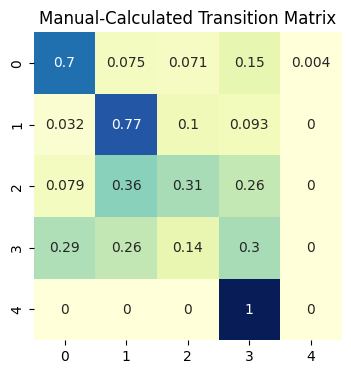

In [84]:
N = 5

MAT = []

for session, j in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    #if j > 0: continue
    title = 'ShortSession'+str(j)
    print(title)
    
    states = np.load(title+"States.npy", allow_pickle = True)
    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    mouse_pos = mouse_pos[mouse_pos['smoothed_acceleration'] <= 60000]
    mouse_pos = patch.DeleteRows(mouse_pos)

    states = np.load(title+"States.npy", allow_pickle = True)
    mouse_pos['states'] = pd.Series(states, index=mouse_pos.index)
    

    grouped = mouse_pos.groupby([pd.Grouper(freq='10S'), 'states']).size()
    prob = grouped.groupby(level=0).apply(lambda g: g / g.sum())
    states_prob = prob.unstack(level=-1).fillna(0)
    states_prob.index = states_prob.index.get_level_values(0)
    
    for i in range(N):
        if i not in states_prob.columns: states_prob[i] = 0
        #states_prob.iloc[0, states_prob.columns.get_loc(i)] = 1e-5
    
    x = np.array([np.array(states_prob[i].to_list()) for i in range(N)])

    states_ = []
    for i in range(len(x[0])):
        current_state = x.T[i]
        states_.append(np.argmax(current_state))


    '''fig, axs = plt.subplots(1, 1, figsize=(35, 4))
    cax = axs.imshow(np.array(states_).reshape(1,-1), aspect="auto", cmap=cmap, vmin=0, vmax=N-1)
    axs.set_ylabel("States")
    axs.set_yticks([])
    cbar = fig.colorbar(cax, ax=axs, orientation='vertical')
    cbar.set_ticks(np.arange(0, N))
    cbar.set_ticklabels([f'State {val}' for val in np.arange(0, N)])   
    plt.tight_layout()
    plt.show()'''
    
    PlotStates(np.array(states_), states_prob, N=5)
    
    manual_trans_mat = np.zeros((N,N))
    for i in range(1,len(states_)): manual_trans_mat[states_[i-1]][states_[i]] += 1

    for i in range(N): 
        if np.sum(manual_trans_mat[i]) != 0: manual_trans_mat[i] = manual_trans_mat[i]/np.sum(manual_trans_mat[i])

    annot_array = np.array([[round(item, 3) for item in row] for row in manual_trans_mat])
    fig, axs = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(manual_trans_mat, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
    axs.set_title("Manual-Calculated Transition Matrix")
    plt.show()
    
    MAT.append(manual_trans_mat)

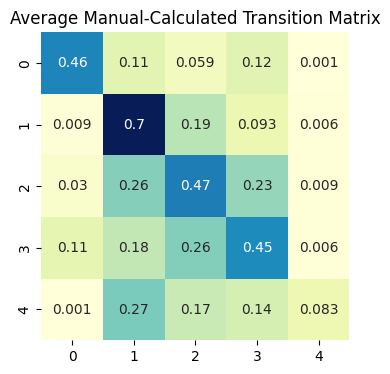

In [74]:
MAT_mean = np.mean(np.array(MAT), axis = 0)

annot_array = np.array([[round(item, 3) for item in row] for row in MAT_mean])
fig, axs = plt.subplots(1,1, figsize=(4, 4))
sns.heatmap(MAT_mean, cmap='YlGnBu', ax = axs, square = 'True', cbar = False, annot=annot_array, annot_kws = {'size':10})
axs.set_title("Average Manual-Calculated Transition Matrix")
plt.show()